In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from cmath import inf

In [3]:
import ase
import matplotlib.pyplot as plt
import metatensor
import numpy as np
import scipy
import torch
from ase.units import Hartree
from IPython.utils import io
from metatensor import Labels
from tqdm import tqdm

In [4]:
import mlelec.metrics as mlmetrics
from mlelec.data.dataset import MLDataset, MoleculeDataset, get_dataloader
from mlelec.features.acdc import compute_features_for_target
from mlelec.utils.twocenter_utils import (
    _to_matrix,
    _to_uncoupled_basis,
    unfix_orbital_order,
)
from src.mlelec.models.linear import LinearTargetModel

In [5]:
torch.set_default_dtype(torch.float64)

------------------ CHANGE THE PARAMETERS -------------

In [6]:
NUM_FRAMES = 7000
BATCH_SIZE = 10
NUM_EPOCHS = 800
SHUFFLE_SEED = 5380
TRAIN_FRAC = 0.7
TEST_FRAC = 0.1
VALIDATION_FRAC = 0.2

In [7]:
LR = 1e-3
VAL_INTERVAL = 10

In [8]:
DEVICE = 'cpu'

In [9]:
ORTHOGONAL = False  # set to 'FALSE' if working in the non-orthogonal basis

Helper function to drop blocks in the train, validation and test subset that have zero samples due to splitting of the dataset

In [10]:
def drop_zero_blocks(train_tensor, val_tensor, test_tensor):
    for i1, b1 in train_tensor.items():
        if b1.values.shape[0] == 0:
            train_tensor = metatensor.drop_blocks(train_tensor,
                                                  Labels(i1.names, i1.values.reshape(1,-1)))
    for i2, b2 in val_tensor.items():
        if b2.values.shape[0] == 0:
            val_tensor = metatensor.drop_blocks(val_tensor,
                                                Labels(i2.names, i2.values.reshape(1,-1)))
    for i3, b3 in test_tensor.items():
        if b3.values.shape[0] == 0:
            test_tensor = metatensor.drop_blocks(test_tensor,
                                                 Labels(i3.names, i3.values.reshape(1,-1)))
    return train_tensor, val_tensor, test_tensor

In [11]:
molecule_data = MoleculeDataset(
    mol_name="acs",
    use_precomputed=True,
    path="examples/data/acs",
    aux_path="examples/data/acs/sto-3g",
    frame_slice=slice(0, NUM_FRAMES, 20),
    device=DEVICE,
    aux=["overlap", "orbitals"],
    lb_aux=["overlap", "orbitals"],
    target=["fock"],
    lb_target=["fock"],
)

Loading structures
examples/data/acs/sto-3g/fock.hickle
examples/data/acs/def2-tzvp/fock.hickle


### Create the ML dataset from the molecular data 

In [12]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=DEVICE,
    model_strategy="coupled",
    shuffle=True,
    shuffle_seed=SHUFFLE_SEED,
    orthogonal=ORTHOGONAL,
)

In [13]:
ml_data._split_indices(train_frac=TRAIN_FRAC, val_frac=VALIDATION_FRAC, test_frac=TEST_FRAC)

In [14]:
hypers = {
            "cutoff": 3.5,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 3.5,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

In [15]:
ml_data._set_features(compute_features_for_target(ml_data, device = DEVICE, hypers = hypers, hypers_pair = hypers_pair))

In [16]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor", batch_size=BATCH_SIZE)

In [17]:
ml_data.target_train, ml_data.target_val, ml_data.target_test = drop_zero_blocks(ml_data.target_train, ml_data.target_val, ml_data.target_test)

In [18]:
ml_data.feat_train, ml_data.feat_val, ml_data.feat_test = drop_zero_blocks(ml_data.feat_train, ml_data.feat_val, ml_data.feat_test)

# RidgeCV Model

## Fitting a RidgeCV model

In [19]:
model = LinearTargetModel(dataset=ml_data, nlayers=1, nhidden=16, bias=False, device=DEVICE)

In [23]:
model.load_state_dict(torch.load("model_epoch_eval_diag_550.pt"))

/tmp/ipykernel_1701571/1460771657.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_epoch_eval_diag_550.pt"))


<All keys matched successfully>

In [40]:
pred_ridges, ridges = model.fit_ridge_analytical(alpha=np.logspace(-8, 3, 12), cv=3, set_bias=False)

Training on large basis targets

In [20]:
def isqrtp(A: torch.Tensor) -> torch.Tensor:
    eva, eve = torch.linalg.eigh(A)
    idx = eva > 1e-15
    return eve[:, idx] @ torch.diag(eva[idx] ** (0.5)) @ eve[:, idx].T

In [21]:
def compute_mulliken(ml_data, focks, overlaps, indices, unfix=True):
    # We access the basis written as a dictionary from ml_data
    basis = ml_data.molecule_data.aux_data['orbitals']
    # We access the ase frames for each structure in the batch
    batch_frames = [ml_data.structures[i] for i in indices]
    # We access the Fock matrices for each structure in the batch
    if unfix:
        batch_fock = unfix_orbital_order(
            focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
        )
    else:
        batch_fock = [focks[i] for i in indices]
    
    #batch_fock = [torch.tensor(i) for i in batch_fock]
    batch_overlap = [overlaps[i] for i in indices]
    #batch_overlap = [torch.tensor(i) for i in batch_overlap]
    # We access the overlap matrices for each structure in the batch
    # batch_overlap = [ml_data.molecule_data.aux_data["overlap"][i] for i in indices] 
    
    #ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    eva = []
    rho_list = []
    pop = []
    density_matrices = []
    P = []
    D = []
    for a in range(len(focks)):

        Hx = xitorch.LinearOperator.m(batch_fock[a])
        Sx = xitorch.LinearOperator.m(batch_overlap[a])
        eval, mo_coeff = symeig(Hx, M = Sx)
        #eval, mo_coeff = torch.linalg.eigh(ortho_focks[a])

        eva.append(eval)
        frame = batch_frames[a]
        S_sqrt = isqrtp(batch_overlap[a])
        # Define the single particle density matrix
        half_nelec = frame.numbers.sum() // 2
        mo_occ = torch.zeros(mo_coeff.shape[1])
        mo_occ[:half_nelec] = 2
        mocc = mo_coeff[:,mo_occ>0]
        dm = (mocc*mo_occ[mo_occ>0]) @ (mocc.conj().T)
        
        natm = len(frame)
        rho = S_sqrt @ dm @ S_sqrt
        rho_list.append(rho)
        density_matrices.append(dm)
        d = torch.zeros((natm, natm))
        for i in range(natm):
            i_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:i]]))
            i_end = i_start + len(basis[frame.numbers[i]])
            for j in range(natm):
                j_start = int(np.sum([len(basis[s]) for s in frame.numbers[0:j]]))
                j_end = j_start + len(basis[frame.numbers[j]])
                d[i, j] = torch.norm(rho[i_start:i_end, j_start:j_end])
        P.append(d)
        D.append(torch.diag(d))
        
 
    return eva, rho_list, P, density_matrices, D

In [43]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix, unfix_orbital_order

In [44]:
uncoupled = _to_uncoupled_basis(pred_ridges, device = model.device)

fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.train_idx,
    ml_data.aux_data['orbitals'],
    device = model.device,
)

In [59]:
pred_eva, _, pred_ard, _, pred_diag = compute_mulliken(ml_data, fock_predictions_train, molecule_data.aux_data['overlap'], ml_data.train_idx, unfix = True)

In [46]:
import xitorch
from xitorch.linalg import symeig

In [23]:
ref_eva_lb, _, ref_ard_lb, _, ref_diag_lb = compute_mulliken(ml_data, ml_data.molecule_data.lb_target['fock'], molecule_data.lb_aux_data['overlap'], range(len(ml_data.target.tensor)), unfix=False)

In [24]:
ref_eva, _, ref_ard, _, ref_diag = compute_mulliken(ml_data, molecule_data.target['fock'],
                                          molecule_data.aux_data['overlap'], 
                                          range(len(ml_data.target.tensor)), unfix=False)

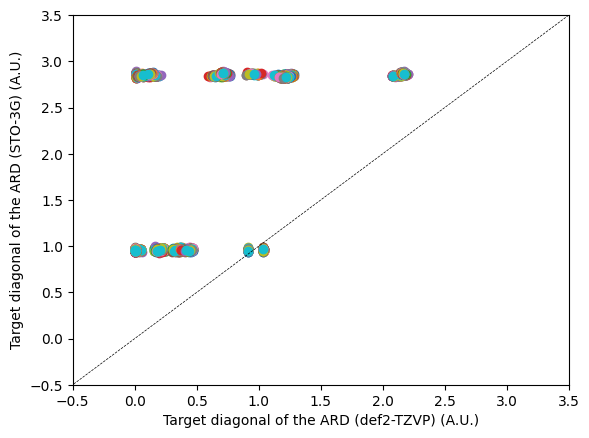

In [30]:
from matplotlib import pyplot as plt
x = [i.detach().numpy().flatten() for i in ref_diag_lb] 
y = [i.detach().numpy().flatten() for i in ref_diag]

fig, ax = plt.subplots()

for i,xi in enumerate(x):
    plt.scatter(xi,y[i])
plt.plot([-100,100], [-100,100], linestyle='--', color='black', linewidth=0.5)  
plt.xlim(-0.5,3.5)
plt.ylim(-0.5,3.5)   
plt.plot(linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target diagonal of the ARD (def2-TZVP) (A.U.)')
plt.ylabel('Target diagonal of the ARD (STO-3G) (A.U.)')
plt.savefig('Target_diagonal_ARD_two_basis.png')
plt.show()

In [61]:
loss_fn(pred_eva[13], ref_eva[13])

tensor(0.2910)

In [68]:
loss_fn(pred_ard[13], ref_ard[13]) * 4

tensor(0.2401)

In [77]:
var_eigval = torch.cat([ref_eva_lb[i].flatten() for i in range(len(ref_eva_lb))]).var()
var_ard = torch.cat([ref_ard_lb[i].flatten() for i in range(len(ref_ard_lb))]).var()
var_diag = torch.cat([ref_diag_lb[i].flatten() for i in range(len(ref_diag_lb))]).var()

In [52]:
var_diag

tensor(0.4074)

In [53]:
var_eigval

tensor(15.9740)

In [54]:
best = inf
early_stop_criteria = 10

Do this only if you want to start your indirect training from the Ridge fitted weights

In [55]:
train_pred = model.forward(ml_data.feat_train, return_type="tensor",
                           batch_indices=ml_data.train_idx, ridge_fit=True)

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=20,
)

In [57]:
val_interval = VAL_INTERVAL
early_stop_count = 0
nepochs = NUM_EPOCHS

In [69]:
loss_fn = getattr(mlmetrics, "L2_loss") 

Initialize lists to store different losses

In [70]:
losses = []
val_losses = []
losses_eva = []
val_losses_eva = []
losses_ard = []
val_losses_ard = []

In [ ]:
iterator = tqdm(range(nepochs))

for epoch in range(nepochs):
    model.train(True)
    train_loss = 0
    train_loss_eva = 0
    train_loss_ard = 0
    
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        # Forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=idx)
        train_ard_ref = [ref_ard_lb[i] for i in idx]
        train_eva_ref = [ref_eva_lb[i][:molecule_data.target['fock'][i].shape[0]] for i in idx]
        # ovlp = [molecule_data.aux_data['overlap'][i] for i in idx]
        pred_eva, _, pred_ard, _, _ = compute_mulliken(ml_data, pred, 
                                                  molecule_data.aux_data['overlap'], idx, unfix=True)

        loss_eva = loss_fn(pred_eva, train_eva_ref)
        loss_ard = loss_fn(pred_ard, train_ard_ref)

        loss = loss_eva + 4 * loss_ard
        
        train_loss += loss.item()
        train_loss_eva += loss_eva.item()
        train_loss_ard += loss_ard.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()

    losses_eva.append(train_loss_eva)
    losses_ard.append(train_loss_ard)
    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)
    
    if epoch % val_interval == 0:
        val_loss = 0
        vloss_eva = 0
        vloss_ard = 0
        
        for data in val_dl:
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=idx)
        
            val_ard_ref = [ref_ard_lb[i] for i in idx]
            val_eva_ref = [ref_eva_lb[i][:ml_data.target.tensor[i].shape[0]] for i in idx]
            # ovlp = [molecule_data.aux_data['overlap'][i] for i in idx]
            val_pred_eva, _, val_pred_ard, _, _ = compute_mulliken(ml_data, val_pred, 
                                                  molecule_data.aux_data['overlap'], idx, unfix=True)

            val_loss_eva = loss_fn(val_pred_eva, val_eva_ref)
            val_loss_ard = loss_fn(val_pred_ard, val_ard_ref)

            vloss = val_loss_eva + 4 * val_loss_ard
                
            val_loss += vloss.item()

        val_losses.append(val_loss)
        
        new_best = val_loss < best
        if new_best:
            best = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss}, val loss {val_loss}")
            # Save last best model
            torch.save(model.state_dict(), f'best_model_eva_ard.pt')
            break
        if epoch % 50 ==0:
            torch.save(model.state_dict(), f'model_epoch_eval_diag_{epoch}.pt')
                       
        if epoch % 10 == 0:
            print("Epoch:", epoch, "train loss:", f"{train_loss:.4g}", "val loss:", f"{val_loss:.4g}")
            print("Train Loss diag:", f"{train_loss_ard:.4g}", "Train Loss eva:", f"{train_loss_eva:.4g}")



  0%|                                                                                                                                                                               | 0/800 [02:50<?, ?it/s]


Epoch: 0 train loss: 274 val loss: 78.97
Train Loss diag: 66.79 Train Loss eva: 6.891


In [ ]:
plt.figure()
plt.loglog(losses, label='Training loss')
plt.loglog(losses_eva, "--", label='Eigenvalue loss')
plt.loglog(losses_ard, "--", label='ARD loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [55]:
with io.capture_output() as captured:
    batch_indices = ml_data.train_idx
    train_fock_predictions = model.forward(
        ml_data.feat_train, return_type="tensor", batch_indices=batch_indices
    )
    train_eva_pred, _, _, _, train_diag_pred = compute_mulliken(
        ml_data, train_fock_predictions, molecule_data.aux_data['overlap'], batch_indices, unfix = True)

In [60]:
train_diag_ref = [ref_diag_lb[i] for i in batch_indices]
train_error_diag = loss_fn(ml_data.train_frames, train_diag_pred, train_diag_ref) / np.sum([np.prod(t.shape) for t in train_diag_ref])

train_eva_ref = [ref_eva_lb[i][:molecule_data.target['fock'][i].shape[0]] for i in batch_indices]
train_error_eva = loss_fn(ml_data.train_frames, train_eva_pred, train_eva_ref) / np.sum([np.prod(t.shape) for t in train_eva_ref])

In [61]:
print("Train RMSE on the diagonal of the ARD from indirect learning {:.5f} A.U.".format(torch.sqrt(train_error_diag).item()))
print("Train RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(train_error_eva).item() * Hartree))

Train RMSE on the diagonal of the ARD from indirect learning 0.00649 A.U.
Train RMSE on MO energies from indirect learning 0.01515 eV.


In [62]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )
    test_eva_pred, _, _, _, test_diag_pred = compute_mulliken(
        ml_data, test_fock_predictions, molecule_data.aux_data['overlap'], batch_indices, unfix = True)

In [63]:
test_diag_ref = [ref_diag_lb[i] for i in batch_indices]
error_diag = loss_fn(ml_data.test_frames, test_diag_pred, test_diag_ref) / np.sum([np.prod(t.shape) for t in test_diag_ref])

test_eva_ref = [ref_eva_lb[i][:ml_data.target.tensor[i].shape[0]] for i in batch_indices]
error_eva = loss_fn(ml_data.test_frames, test_eva_pred, test_eva_ref) / np.sum([np.prod(t.shape) for t in test_eva_ref])

In [64]:
print("Test RMSE on the diagonal of the ARD from indirect learning {:.5f} A.U.".format(torch.sqrt(error_diag).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(error_eva).item() * Hartree))

Test RMSE on the diagonal of the ARD from indirect learning 0.01662 A.U.
Test RMSE on MO energies from indirect learning 0.04151 eV.


In [ ]:
ml_data.test_frames.

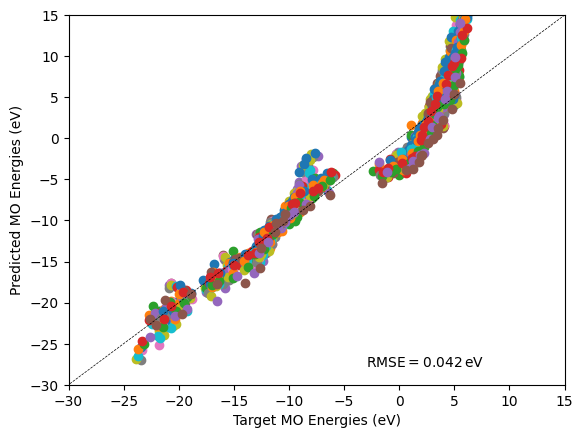

In [65]:
from matplotlib import pyplot as plt
x = [(i * Hartree).detach().numpy() for i in test_eva_ref]
y = [(i * Hartree).detach().numpy() for i in test_eva_pred]

fig, ax = plt.subplots()

for i,xi in enumerate(x):
    plt.scatter(xi,y[i])


plt.text(0.6, 0.05, fr'$\mathrm{{RMSE}}={torch.sqrt(error_eva).item() * Hartree:.3f}\,$eV', transform = ax.transAxes, ha = 'left')    
plt.plot([-100,100], [-100,100], linestyle='--', color='black', linewidth=0.5)
plt.xlim(-30,15)
plt.ylim(-30,15)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
#plt.savefig('MOs_linear_model_upscaled_5_eva_ard_no_var.png')
plt.show()

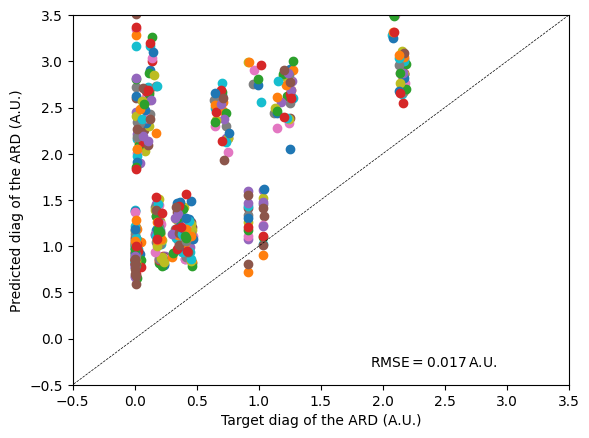

In [66]:
from matplotlib import pyplot as plt
x = [i.detach().numpy().flatten() for i in test_diag_ref] 
y = [i.detach().numpy().flatten() for i in test_diag_pred]

fig, ax = plt.subplots()

for i,xi in enumerate(x):
    plt.scatter(xi,y[i])
plt.plot([-100,100], [-100,100], linestyle='--', color='black', linewidth=0.5)  
plt.xlim(-0.5,3.5)
plt.ylim(-0.5,3.5)
plt.text(0.6, 0.05, fr'$\mathrm{{RMSE}}={torch.sqrt(error_diag).item():.3f}\,$A.U.', transform = ax.transAxes, ha = 'left')    
plt.plot(linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target diag of the ARD (A.U.)')
plt.ylabel('Predicted diag of the ARD (A.U.)')
#plt.savefig('ARDs_linear_model_upscaled_5_eva_ard_no_var.png')
plt.show()

Evaluation of the dipole moment

In [67]:
def compute_dipole_moment(frames, fock_predictions, overlaps, basis = 'sto-3g'):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1, unit="A.U.")
        dipoles.append(dip)
    return torch.stack(dipoles)

In [68]:
def unfix_orbital_order(
    matrix,
    frames,
    orbital,
):
    def unfix_one_matrix(
        matrix, frame, orbital
    ):
        idx = []
        iorb = 0
        atoms = list(frame.numbers)
        for atom_type in atoms:
            cur = ()
            for _, a in enumerate(orbital[atom_type]):
                n, l, _ = a
                if (n, l) != cur:
                    if l == 1:
                        idx += [iorb + 2, iorb, iorb + 1]
                    else:
                        idx += range(iorb, iorb + 2 * l + 1)
                    iorb += 2 * l + 1
                    cur = (n, l)
        return matrix[idx][:, idx]

    if isinstance(frames, list):
        if len(frames) == 1:
            matrix = matrix.reshape(1, *matrix.shape)
        # assert len(matrix.shape) == 3  # (nframe, nao, nao)
        fixed_matrices = []
        for i, f in enumerate(frames):
            fixed_matrices.append(unfix_one_matrix(matrix[i], f, orbital))
        if isinstance(matrix, np.ndarray):
            return np.asarray(fixed_matrices)
        return fixed_matrices
        # return torch.stack(fixed_matrices)
    else:
        return unfix_one_matrix(matrix, frames, orbital)

In [69]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },

    'def2-tzvp': {1: [[1, 0, 0], [2, 0, 0], [3, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]],
                  6: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]],
                  7: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]],
                  8: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]]
                 }
}

In [70]:
dl_frames = [ml_data.structures[A] for A in ml_data.test_idx]

fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    ml_data.aux_data['orbitals'],
)

fock_sto3g = [molecule_data.target['fock'][i] for i in ml_data.test_idx]

fock_targets = [molecule_data.lb_target['fock'][i] for i in ml_data.test_idx]
    
over_small = [molecule_data.aux_data['overlap'][i] for i in ml_data.test_idx]

over_large = [molecule_data.lb_aux_data['overlap'][i] for i in ml_data.test_idx]

In [71]:
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf

In [72]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
with io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_large,
        basis = 'def2-tzvp'
    )

with io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_small,
        basis = 'sto-3g'
    )

with io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_small,
        basis = 'sto-3g'
    )

Text(0, 0.5, 'Predicted dipoles (D)')

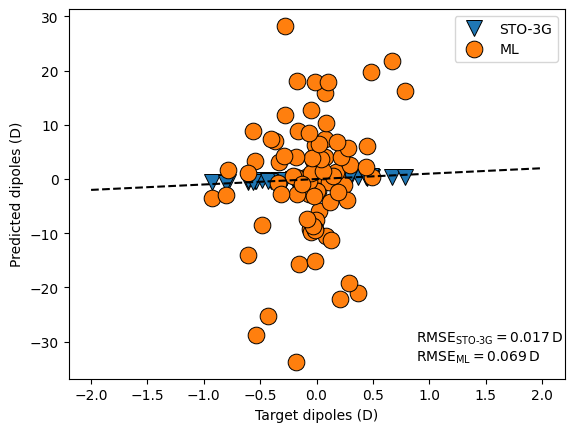

In [48]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()
ax.plot([-2,2], [-2, 2], '--k')


ax.text(0.7, 0.1, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
ax.text(0.7, 0.05, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')
#plt.savefig('Dipoles_linear_model_upscaled_5_eva_ard.png')

Text(0, 0.5, 'Predicted Polarisability (A.U.)')

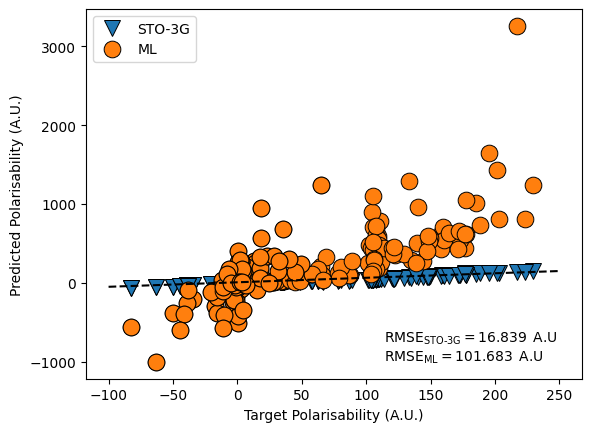

In [49]:
from torch.autograd.functional import jacobian

def compute_polarisability(frames, fock_predictions, overlaps, basis):
    """
    Compute the polarisability for different frames given the fock matrices.
    
    """
    polarisability = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        ao_dip = mol.intor("int1e_r", comp=3)
        ao_dip = ops.convert_to_tensor(ao_dip)
        mf = hf.SCF(mol)
        fock = fock_predictions[i]
        ovlp = overlaps[i]

        def apply_perturb(E):
            p_fock = fock + pynp.einsum("x,xij->ij", E, ao_dip)
            mo_energy, mo_coeff = mf.eig(p_fock, ovlp)
            mo_occ = mf.get_occ(mo_energy)
            mo_occ = ops.convert_to_tensor(mo_occ)
            dm1 = mf.make_rdm1(mo_coeff, mo_occ)
            dip = mf.dip_moment(dm=dm1, unit="A.U.")
            return dip

        E = torch.zeros((3,), dtype=float)
        pol = jacobian(apply_perturb, E)
        polarisability.append(pol)

    return torch.stack(polarisability)

with io.capture_output():
    polar_targets = compute_polarisability(
        dl_frames,
        fock_targets,
        over_large,
        basis = 'def2-tzvp'
    )

with io.capture_output():
    polar_predictions = compute_polarisability(
        dl_frames,
        fock_predictions,
        over_small,
        basis = 'sto-3g'
    )

with io.capture_output():
    polar_sto3g = compute_polarisability(
        dl_frames,
        fock_sto3g,
        over_small,
        basis = 'sto-3g'
    )


fig, ax = plt.subplots()

x = polar_targets.flatten().detach().cpu()
y_sto3g = polar_sto3g.flatten().detach().cpu()
y_ml = polar_predictions.flatten().detach().cpu()

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()
ax.plot([-100,250], [-50,150], '--k')


ax.text(0.6, 0.1, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$ A.U', transform = ax.transAxes, ha = 'left')
ax.text(0.6, 0.05, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$ A.U', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target Polarisability (A.U.)')
ax.set_ylabel('Predicted Polarisability (A.U.)')
#plt.savefig('Polarizability_linear_model_upscaled_5_eva_ard.png')